# This script demonstrates how to build a multi-modal variational autoencoder with vae_tools

In [1]:
import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.datasets import mnist
import numpy as np
import numpy
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
import vae_tools.nb_tools
vae_tools.nb_tools.notebook_resize()
# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image


keras version: 2.1.6-tf
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs True


In [2]:
# Load and investigate data
#data = np.load(file = "/mnt/filedump1/drudolph/old_data/data_steps_1000_color_11_shape_6_reflectivity_2_2019-01-17_15:58:15.npy", encoding='bytes')
#data = np.load(file = "/mnt/filedump1/drudolph/new_data/data_steps_1010_color_2_shape_2_reflectivity_2_2019-01-23_12:58:11.npy", encoding='bytes')

In [3]:
def loader():
    filename = "/mnt/filedump1/drudolph/new_data/data_steps_1010_color_2_shape_2_reflectivity_2_2019-01-23_12:58:11.npy"
    filename = "/mnt/filedump1/drudolph/new_data/color_2_shape_2_reflectivity_2_2019-01-23_22:21:14.npy"

    data = np.load(filename, encoding='bytes')

    range_data = data[:, 0]
    camera_data = data[:, 1]
    reflectivity_data = data[:, 2]

    print("range_data", range_data.shape)
    print("camera_data", camera_data.shape)
    print("reflectivity_data", reflectivity_data.shape)
    #return range_data, camera_data, reflectivity_data
    return range_data, camera_data, reflectivity_data
#loader()

In [4]:
#range_data, camera_data, reflectivity_data = loader()
range_data, camera_data, reflectivity_data = loader()


range_data (10001, 3)
camera_data (10001, 3)
reflectivity_data (10001, 3)


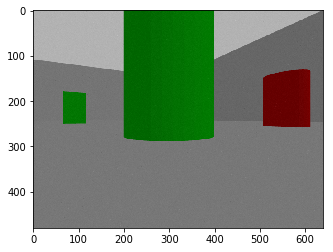

Cut the image to  (40, 640, 3)


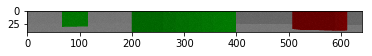

In [5]:
# Get one image and show the result
_data = camera_data[17,1]
resolution = (640,480) # (800,800)
image_data = _data.tobytes() # byte values of the image
image = numpy.asarray(Image.frombytes('RGB', resolution, image_data))
# Show
plt.imshow(image)
plt.show()
print("Cut the image to ", image[220:260,:,:].shape)
plt.imshow(image[220:260,:,:])
plt.show()


In [6]:
# Process the images
window_height = [325,375]
window_height = [240,241]
images = np.zeros(shape=(len(camera_data),resolution[1],resolution[0],3))
images_windowed = np.zeros(shape=(len(camera_data),window_height[1] - window_height[0],resolution[0],3))
images_windowed_flat = np.zeros(shape=(len(camera_data),(window_height[1] - window_height[0]) * resolution[0] * 3))
for idx in range(len(camera_data)):
    #print(camera_data)
    #print(np.frombuffer(camera_data[idx,1], dtype=np.uint8).reshape(resolution[1],resolution[0],3).shape)
    images[idx,:,:,:] = numpy.asarray(Image.frombytes('RGB', resolution, camera_data[idx,1].tobytes()))/255.0
    #images[idx,:,:,:] = np.frombuffer(camera_data[idx,1], dtype=np.uint8).reshape(resolution[0],resolution[1],3)/255.0
    images_windowed[idx,:,:,:] = images[idx,window_height[0]:window_height[1],:,:]
    images_windowed_flat[idx,:] = images_windowed[idx].flatten()
    #images[idx]

X = images_windowed_flat

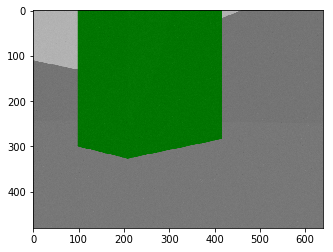

Cut the image to  (40, 640, 3)


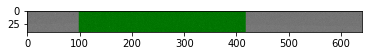

In [18]:
# Sanity Check of the images
resolution = (640,480)
img_idx = 8
img = Image.fromarray((images[img_idx] * 255.0).astype(np.uint8), 'RGB')
#img.show()
image = numpy.asarray(img) / 255.0
# Show
plt.imshow(image)
plt.show()
print("Cut the image to ", image[220:260,:,:].shape)
plt.imshow(image[220:260,:,:])
plt.show()

0.0
0.0


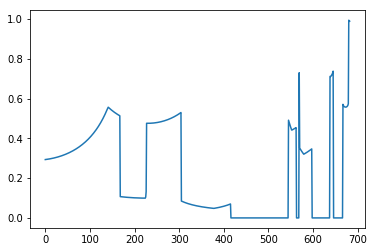

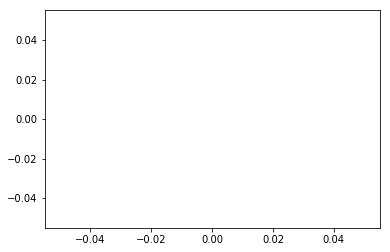

In [19]:
# Process th ranges and reflections
range_data, camera_data, reflectivity_data 
ranges = np.zeros(shape=(len(range_data),len(range_data[0,1])))
reflections = np.zeros(shape=(len(reflectivity_data),len(reflectivity_data[0,1])))
for idx in range(len(range_data)):
    ranges[idx] = range_data[idx,1]
    reflections[idx] = reflectivity_data[idx,1]
# normalization
ranges[ranges == np.inf] = 0
#print(np.min(ranges))
#print(np.max(ranges))
print(np.min(reflections))
print(np.max(reflections))
ranges = ranges - np.min(ranges)
ranges = ranges / np.max(ranges)
reflections = reflections / np.max([np.max(reflections), -np.min(reflections)])
reflections = reflections - np.min(reflections)
reflections = reflections / np.max(reflections)
#print(np.min(reflections))
#print(np.max(reflections))


plt.plot(ranges[img_idx])
plt.show()
plt.plot(reflections[img_idx])
plt.show()


In [10]:
# input image dimensions
img_rows, img_cols, img_chns = window_height[1] - window_height[0], resolution[0], 3
batch_size = 128
img_original_dim = img_rows * img_cols * img_chns
lidar_original_dim = len(range_data[0,1])
intermediate_dim = 256
epochs = 100
z_dim = 2
beta = 1.

encoder = [[
    Input(shape=(img_original_dim,)),
    Dense(intermediate_dim, activation='relu'),
    Dense(int(intermediate_dim/2), activation='relu')
],
[
    Input(shape=(lidar_original_dim,)),
    Dense(intermediate_dim, activation='relu'),
    Dense(int(intermediate_dim/2), activation='relu')
],
[
    Input(shape=(lidar_original_dim,)),
    Dense(intermediate_dim, activation='relu'),
    Dense(int(intermediate_dim/2), activation='relu')
]]

decoder = [[
    Dense(int(intermediate_dim/2), activation='relu'),
    Dense(intermediate_dim, activation='relu'),
    Dense(img_original_dim, activation='sigmoid')
],
[
    Dense(int(intermediate_dim/2), activation='relu'),
    Dense(intermediate_dim, activation='relu'),
    Dense(lidar_original_dim, activation='sigmoid')
],
[
    Dense(int(intermediate_dim/2), activation='relu'),
    Dense(intermediate_dim, activation='relu'),
    Dense(lidar_original_dim, activation='sigmoid')
]]

# encoder = [[
#     Input(shape=(img_original_dim,)),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(int(intermediate_dim/2), activation='relu')
# ],
# [
#     Input(shape=(lidar_original_dim,)),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(int(intermediate_dim/2), activation='relu')
# ]]

# decoder = [[
#     Dense(int(intermediate_dim/2), activation='relu'),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(img_original_dim, activation='sigmoid')
# ],
# [
#     Dense(int(intermediate_dim/2), activation='relu'),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(lidar_original_dim, activation='sigmoid')
# ]]


# encoder = [[
#     Input(shape=(lidar_original_dim,)),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(int(intermediate_dim/2), activation='relu')
# ]]

# decoder = [[
#     Dense(int(intermediate_dim/2), activation='relu'),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(lidar_original_dim, activation='sigmoid')
# ]]

vae_obj = MmVae(z_dim, encoder, decoder, [img_original_dim, lidar_original_dim, lidar_original_dim], beta = 0.01, beta_is_normalized = True, reconstruction_loss_metrics = [ReconstructionLoss.MSE], name='MmVae')
#vae_obj = MmVae(z_dim, encoder, decoder, [lidar_original_dim], beta = beta, reconstruction_loss_metrics = [ReconstructionLoss.MSE], name='MmVae')

vae = vae_obj.get_model()
vae.compile(optimizer='adam', loss=None)
#vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

A: [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 683) dtype=float32>]
A: [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>, <tf.Tensor 'input_3:0' shape=(?, 683) dtype=float32>]
A: [<tf.Tensor 'input_2:0' shape=(?, 683) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 683) dtype=float32>]
A: [<tf.Tensor 'input_2:0' shape=(?, 683) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_2:0' shape=(?, 683) dtype=float32>, <tf.Tensor 'input_3:0' shape=(?, 683) dtype=float32>]
A: [<tf.Tensor 'input_3:0' shape=(?, 683) dtype=float32>]  is proper subset of B: [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>, <tf.Tensor 'input_3:0' shape=(?, 683) dtype=float32>]
A: [<tf.Tensor 'input_3:0' shape=(?, 68

In [ ]:
x_train = [images_windowed_flat, ranges, reflections]
# x_train = [images_windowed_flat, ranges]
# x_train = [images_windowed_flat]
# x_train = [reflections]

# Store the losses to a history object for plotting
losses_cb = vae_tools.callbacks.Losses(data = x_train)
# Train
vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            verbose = 0,
            callbacks=[losses_cb])

In [ ]:
# Show the losses
import matplotlib
import matplotlib.pyplot as plt
num_losses = len(losses_cb.history.values())
f, axs = plt.subplots(num_losses, 1, sharex=True, figsize=[10,50], dpi=96)
axs[0].set_title("Losses")
for idx in range(num_losses):
    axs[idx].plot(list(losses_cb.history.values())[idx])
    axs[idx].set_xlabel([list(losses_cb.history.keys())[idx]])
plt.show()

In [ ]:
# Store the models
vae_obj.store_model_powerset(prefix = 'models/enc_mean_xwv_', model_inputs = vae_obj.encoder_inputs,
                     get_model_callback = vae_obj.get_encoder_mean)
vae_obj.store_model_powerset(prefix = 'models/enc_logvar_xwv_', model_inputs = vae_obj.encoder_inputs,
                     get_model_callback = vae_obj.get_encoder_logvar)
vae_obj.store_model(name = 'models/decoder_xwv', model = vae_obj.get_decoder(), overwrite = True)
# Load the models
encoder_mean_models, bitmask =  vae_obj.load_model_powerset(prefix = 'models/enc_mean_xwv_', num_elements = len(vae_obj.encoder_inputs))
encoder_logvar_models, bitmask =  vae_obj.load_model_powerset(prefix = 'models/enc_logvar_xwv_', num_elements = len(vae_obj.encoder_inputs))
decoder_model =  vae_obj.load_model(name = 'models/decoder_xwv')


In [ ]:
import vae_tools.metrics
X,W,V = images_windowed_flat, ranges, reflections
data_idx = 17

# Get the encoding of x (100 = 1, but we start at 0 => 100 = 0)
encoder_idx = 0
#vae_tools.viz.plot_model(encoder_mean_models[encoder_idx])
obs = X[[data_idx],:]
print("Prediction of x", str(encoder_mean_models[encoder_idx].predict(obs)))

# Get the encoding of x and w (110 = 3, but we start at 0 => 110 = 2)
encoder_idx = 2
#vae_tools.viz.plot_model(encoder_mean_models[encoder_idx])
obs = [X[[data_idx],:],W[[data_idx],:]]
print("Prediction of x & w", str(encoder_mean_models[encoder_idx].predict(obs)))

# Get the D_KL of x, v, and w (111 = 7, but we start at 0 => 111 = 6)
encoder_idx = 6
#vae_tools.viz.plot_model(encoder_models[encoder_idx])
obs = [X[[data_idx],:],W[[data_idx],:],V[[data_idx],:]]
mean = encoder_mean_models[encoder_idx].predict(obs)
logvar = encoder_logvar_models[encoder_idx].predict(obs)
print("D_KL of predicting x,w,v", str(np.sum(vae_tools.metrics.kl_loss_n(mean, logvar))))

# Get the D_KL of x, v, and w (111 = 7, but we start at 0 => 111 = 6)
encoder_idx = 6
#vae_tools.viz.plot_model(encoder_models[encoder_idx])
obs = [X[[data_idx],:],W[[data_idx],:],V[[data_idx],:]]
mean = encoder_mean_models[encoder_idx].predict(obs)
logvar = encoder_logvar_models[encoder_idx].predict(obs)
d_kl = np.sum(vae_tools.metrics.kl_loss_n(mean, logvar))
reconstruction = decoder_model.predict(mean)
x_rec_loss = vae_tools.metrics.binary_cross_entropy(reconstruction[0], np.clip(obs[0],0.001,0.999))
w_rec_loss = vae_tools.metrics.binary_cross_entropy(reconstruction[1], np.clip(obs[1],0.001,0.999))
v_rec_loss = vae_tools.metrics.binary_cross_entropy(reconstruction[2], np.clip(obs[2],0.001,0.999))
print("ELBO: ", d_kl + x_rec_loss + w_rec_loss + v_rec_loss)